In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


In [2]:
spark = SparkSession.builder.appName('ga').getOrCreate()

### load data of selected days

In [60]:
from os import listdir
from os.path import isfile, join

directory = '/Users/ing/Documents/google analysis/data/'
fileList = os.listdir(directory)
fileList = [f for f in fileList if 'csv' in f]
fileList

['ga_sessions_20160802.csv',
 'ga_sessions_20160803.csv',
 'ga_sessions_20160801.csv']

In [62]:
startDate = '20160801'
stopDate = '20160803'

selectedDate = [f for f in fileList if (f >= 'ga_sessions_'+startDate+'.csv' and f <= 'ga_sessions_'+stopDate+'.csv')]
selectedDatepaths = [directory + f for f in selectedDate]

# "dir1/,dir2/,dir3/*"

df = spark.read.format('csv') \
  .option("inferSchema", True) \
  .option("maxColumns", "540000") \
  .option("header", True) \
  .option("sep", "\t") \
  .load(selectedDatepaths)

In [63]:
df.toPandas().head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,None,5,1470191844,1470191844,20160802,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Oceania', 'subContinent': 'Aust...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 19, 'minu...",9932908116119920975,None,Organic Search,Not Socially Engaged
1,None,2,1470127145,1470127145,20160802,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...",[],"""[{'hitNumber': 1, 'time': 0, 'hour': 1, 'minu...",5320937337095104430,None,Direct,Not Socially Engaged
2,None,1,1470176183,1470176183,20160802,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...","[{'index': 4, 'value': 'EMEA'}]","""[{'hitNumber': 1, 'time': 0, 'hour': 15, 'min...",2314762785260651364,None,Organic Search,Not Socially Engaged
3,None,1,1470169596,1470169596,20160802,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",1144912080450618887,None,Direct,Not Socially Engaged
4,None,1,1470180889,1470180889,20160802,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 16, 'minu...",1408951569184570430,None,Direct,Not Socially Engaged


In [64]:
df.count()

6741

## count visitor number

### timestamp converting

In [144]:
# #转换成localtime
# time_local = time.localtime(timestamp)
# #转换成新的时间格式(2016-05-05 20:28:54)
# dt = time.strftime("%Y-%m-%d %H:%M:%S",time_local)
import time

def visitStartTimeConvert(x):
    t = time.localtime(x["visitStartTime"])
    
    return (x['fullVisitorId'], time.strftime('%Y%m%d%H%M%S',t))

visitStartTimeConverted = df.rdd.map(visitStartTimeConvert)
visitStartTimeConverted.take(5)

[(Decimal('9932908116119920975'), '20160803103724'),
 (Decimal('5320937337095104430'), '20160802163905'),
 (Decimal('2314762785260651364'), '20160803061623'),
 (Decimal('1144912080450618887'), '20160803042636'),
 (Decimal('1408951569184570430'), '20160803073449')]

### visitors per hour

In [168]:
def groupByHour(x):
    return (x[0], x[1][:10])

visitHour = visitStartTimeConverted.map(groupByHour).distinct()
visitHour = visitHour.map(lambda x: (x[1], 1))

visitHour = visitHour.reduceByKey(lambda x, y: x + y)
visitHour = visitHour.sortByKey(ascending=True)
visitHour.take(5)

[('2016080115', 38),
 ('2016080116', 41),
 ('2016080117', 51),
 ('2016080118', 43),
 ('2016080119', 40)]

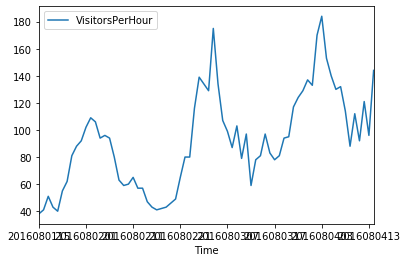

In [174]:
visitsPerHour = visitHour.toDF().toPandas()
visitsPerHour.columns = ['Time','VisitorsPerHour']
visitsPerHour.plot(x ='Time', y='VisitorsPerHour', kind = 'line')
plt.show()

In [176]:
csv_name_h = 'visitsPerHour' + startDate + 'to' + stopDate + '.csv'
visitsPerHour.to_csv(csv_name_h)

### visitors per minute

In [171]:
def groupByMin(x):
    return (x[0], x[1][:12])

visitMin = visitStartTimeConverted.map(groupByMin).distinct()
visitMin = visitMin.map(lambda x: (x[1], 1))

visitMin = visitMin.reduceByKey(lambda x, y: x + y)
visitMin = visitMin.sortByKey(ascending=True)
visitMin.take(5)

[('201608011500', 1),
 ('201608011504', 2),
 ('201608011506', 2),
 ('201608011508', 1),
 ('201608011510', 2)]

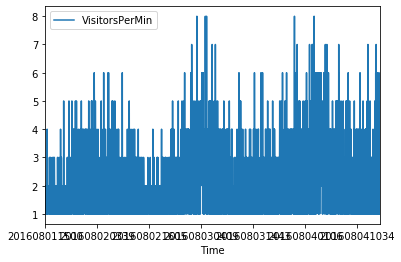

In [178]:
visitsPerMin = visitMin.toDF().toPandas()
visitsPerMin.columns = ['Time','VisitorsPerMin']
visitsPerMin.plot(x ='Time', y='VisitorsPerMin', kind = 'line')
plt.show()

In [179]:
csv_name_m = 'visitsPerMin' + startDate + 'to' + stopDate + '.csv'
visitsPerMin.to_csv(csv_name_m)